In [9]:
import pandas as pd
import wikipedia

In [20]:
artificial_intelligence = wikipedia.page("Artificial intelligence")

In [22]:
artificial_intelligence.content

'Artificial intelligence (AI) is intelligence demonstrated by computers, as opposed to human or animal intelligence. "Intelligence" encompasses the ability to learn and to reason, to generalize, and to infer meaning.AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), understanding human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at the highest level in strategic game systems (such as chess and Go).Artificial intelligence was founded as an academic discipline in 1956, and in the years since it has experienced several waves of optimism, followed by disappointment and the loss of funding (known as an "AI winter"), followed by new approaches, success, and renewed funding. AI research has tried and discarded many different approaches, including simulating the brain, modeling human problem solv

In [23]:
import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

In [24]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [25]:
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

In [26]:
def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i]) + "."

    return long_text

In [27]:
discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]


def extract_sections(
    wiki_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a Wikipedia page, discarding the references and other low information sections
    """
    if len(wiki_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("==+ .* ==+", wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

In [29]:
ai = extract_sections(artificial_intelligence.content, artificial_intelligence.title)
ai[-1]

('Artificial intelligence', 'Explanatory notes', '', 2)

We create a dataset and filter out any sections with fewer than 40 tokens, as those are unlikely to contain enough context to ask a good question.

In [32]:
res = []
for page in wikipedia.search("artificial intelligence"):
    try:
        page = wikipedia.page(page)
        res += extract_sections(page.content, page.title)
    except:
        print(f"Error with {page}")

df = pd.DataFrame(res, columns=["title", "section", "text", "ntokens"])
df.head()

Error with Generative artificial intelligence
Error with <WikipediaPage 'A.I. Artificial Intelligence'>


,title,section,text,ntokens
0,Artificial intelligence,Summary,Artificial intelligence (AI) is intelligence d...,536
1,Artificial intelligence,History,Artificial beings with intelligence appeared a...,1113
2,Artificial intelligence,Goals,The general problem of simulating (or creating...,50
3,Artificial intelligence,"Reasoning, problem-solving",Early researchers developed algorithms that im...,120
4,Artificial intelligence,Knowledge representation,Knowledge representation and knowledge enginee...,335


In [35]:
df.to_csv("../data/artificial_intelligence.csv", index=False)

## Exploring the data

In [37]:
df.title.value_counts().head()

title
Applications of artificial intelligence    80
History of artificial intelligence         48
Artificial intelligence                    43
Symbolic artificial intelligence           37
Artificial general intelligence            28
Name: count, dtype: int64

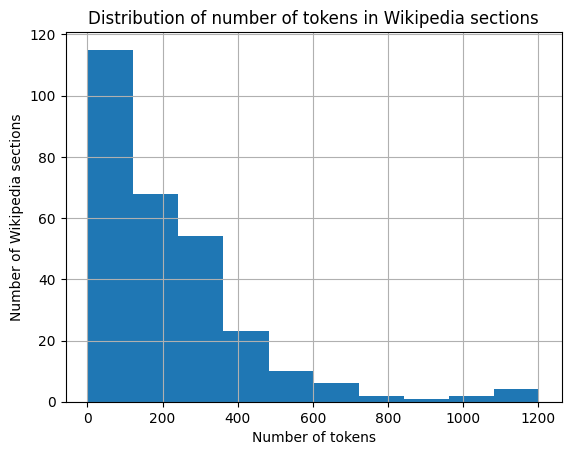

In [38]:
import matplotlib.pyplot as plt

df = pd.read_csv("../data/artificial_intelligence.csv")
df[['ntokens']].hist()

# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()

We can see that the majority of section are fairly short (less than 500 tokens).